# GO/STOP! - Object Detection 시스템 만들기

### RetinaNet을 사용한다.
1-stage detector

### * 실습 목표
1. 바운딩 박스 데이터셋을 전처리할 수 있다.
2. Object detection 모델을 학습할 수 있다.
3. Detection 모델을 활용한 시스템을 만들 수 있다.

### * 학습 내용
1. 자율주행 보조장치
2. RetinaNet
3. Keras-retinanet
4. 프로젝트: 자율주행 보조 시스템 만들기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

print('=3')

=3


In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

print('=3')

=3


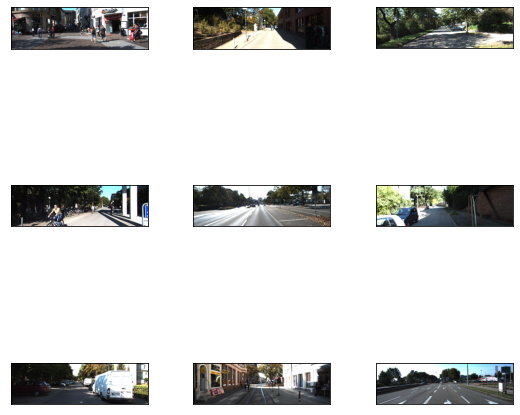

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

## 8-3. 자율주행 보조장치 (2) 데이터 직접 확인하기

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.7 , 1.64], dtype=float32)>, 'bbox': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.42168   , 0.41061193, 0.5122667 , 0.44844607],
       [0.47688   , 0.45328504, 0.5187733 , 0.47110307]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.5 , 1.7 , 4.21],
       [1.48, 1.87, 4.42]], dtype=float32)>, 'location': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-3.63,  1.99, 34.57],
       [-3.52,  2.24, 71.08]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>, 'rotation_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.59, 1.59], dtype=float32)>, 'truncated': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>, 'type': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>}


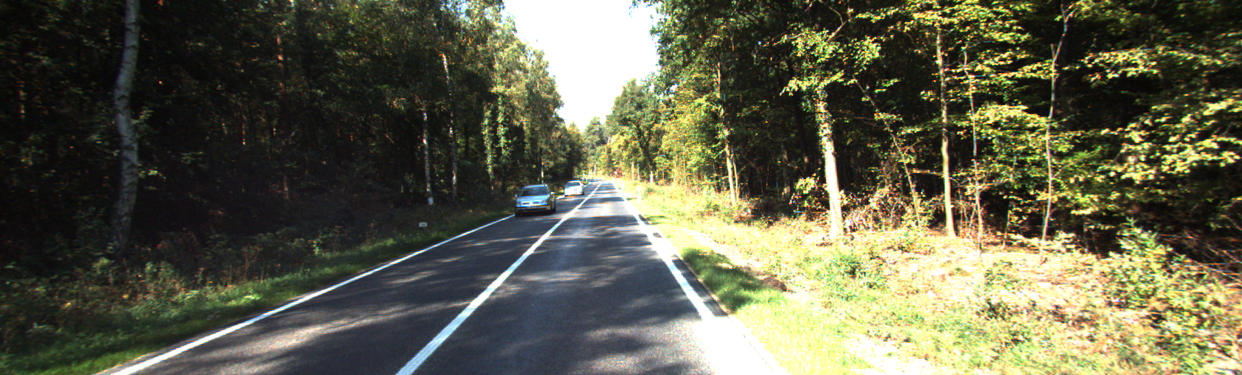

In [5]:
sample = ds_train.take(1) #.take(1) 데이터를 하나씩 뽑는다.

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]
    
print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242 height: 375
(2, 4)
[509.98    216.87    556.97003 182.9    ]
[562.98004 196.17    585.11    180.46   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F206832AD90>


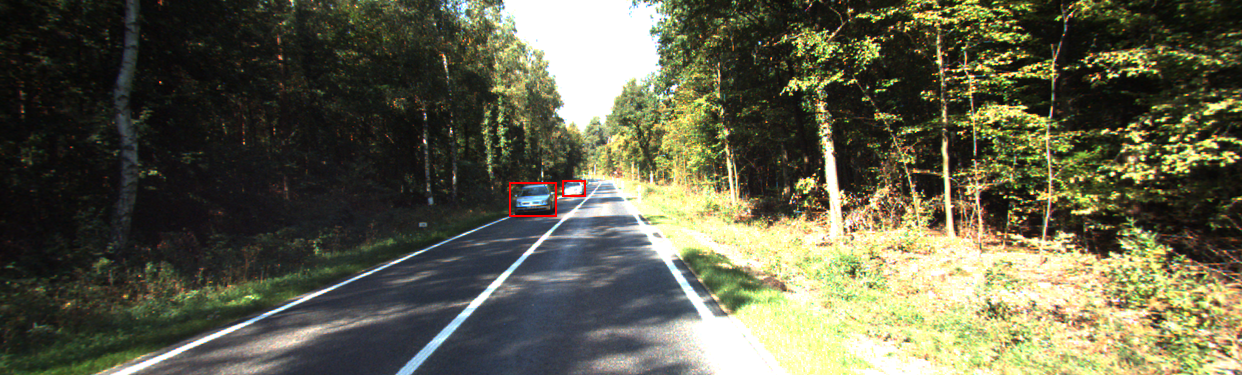

In [6]:
def visualize_bbox(input_image, object_bbox):
    input_image  = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    #바운딩 박스 좌표(x_min, x_max, y_min, y_max)구하기
    width,height=img.size
    print('width:',width, 'height:',height)
    print(object_bbox.shape)
#     print(object_bbox)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운당 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis = 1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image
    
visualize_bbox(img, objects['bbox'].numpy())

## RetinaNet

## keras-retinanet 실습하기 -데이터 포맷 변경

In [7]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)
    

100%|██████████| 6347/6347 [22:27<00:00,  4.71it/s]


In [8]:
# 데이터프레임 생성하기
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:37<00:00,  4.53it/s]


In [9]:
# 클래스 매핑
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    # 클래스 딕셔너리 만들기
    class_type = {"car":0, "person":1}
    
    # 파일불러와서 키, 밸류로 출려가하기
    with open(path, mode='w', encoding='utf-8')as f:
        for k,v in class_type.items():
            f.write(f"{k},{v}\n")
    print("완료")


save_class_format(class_txt_path)

완료


## keras-retinanet실습 -세팅

사전 세팅>  
pip install tensorflow==2.3.0//높은 버전에서 RetinaNet이 안될 수 있어서 변경  
git clone https://github.com/fizyr/keras-retinanet.git  
cd keras-retinanet && python setup.py build_ext --inplace  
pip install -r requirements.txt  
pip install .


In [10]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-10-20 02:45:45.164738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-20 02:45:46.945957: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-20 02:45:46.946893: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-20 02:45:46.955748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-20 02:45:46.955785: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-20 02:45:46.958893: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-20

In [ ]:
# 케라스 모델로 변환
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

In [12]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[193.10533 136.70596 354.00467 237.30154]
[593.46356 176.47864 626.6043  205.94005]
[374.76508 185.0725  420.58594 210.28593]
[532.1792  162.40367 565.36414 192.45572]
[442.01328 176.20984 474.22192 200.24852]


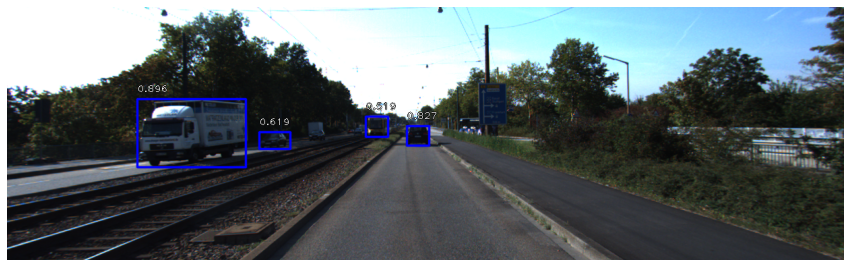

In [14]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)

[769.05396 125.72892 844.1413  313.81934]
[779.83826 145.64986 825.69    280.13602]


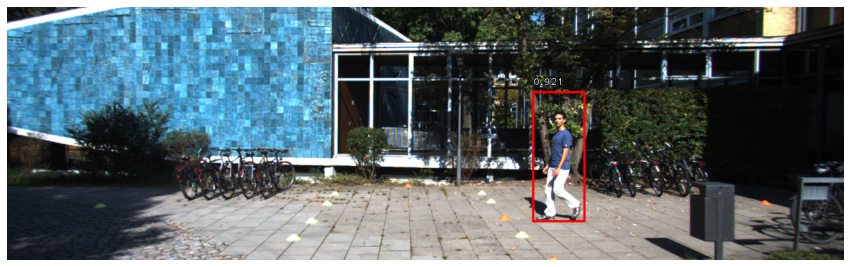

In [15]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

# 프로젝트: 자율주행 보조 시스템 만들기

## 1. 자율주행 시스템 만들기

다음 조건을 만족하는 함수를 만든다.
* input으로 이미지 경로를 받는다.
* 조건에 따라 "Stop"과 "Go"를 return
* 그 조건은 다음과 같다.
1) 사람이 있는 경우
2) 차량의 크기가 300px이상인 경우

In [16]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
    image = read_image(img_path)
    width, height=image.size
    print('width:',width,'heigth:',height)
    
		# 정지조건에 맞으면 return "Stop"
    if (size_limit >= width or height):
        return "Stop"
    else :
        return "Go"
		# 아닌 경우 return "Go"

print(self_drive_assist(img_path))

NameError: name 'read_image' is not defined